In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import imageio
import os
from tqdm import tqdm
import gc
import random
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


2023-11-02 18:38:56.783454: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 18:38:56.829838: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 18:38:56.829892: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 18:38:56.829932: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 18:38:56.837540: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 18:38:56.838190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:

brain_cancer_path = 'mcc2'


In [3]:
directories = []
for directory in os.listdir(brain_cancer_path):
    directories.append(directory)
print('Classes Present : ',list(directories))


Classes Present :  ['all_pre', 'all_early', 'oral_scc']


In [4]:
all_pre_files=[]
all_early_files = []
oral_scc_files = []
all_benign_files = []
oral_normal_files = []
all_pro_files = []
for directory in directories:
    for files in os.listdir(os.path.join(brain_cancer_path,directory)):
        if directory == 'all_pre':
            all_pre_files.append(os.path.join(brain_cancer_path,'all_pre',files))
        elif directory == 'all_early':
            all_early_files.append(os.path.join(brain_cancer_path,'all_early',files))
        elif directory == 'oral_scc':
            oral_scc_files.append(os.path.join(brain_cancer_path,'oral_scc',files))
       


In [5]:
print('Total all_pre_files : ',len(all_pre_files))
print('Total all_early_files : ',len(all_early_files))
print('Total oral_scc_files : ',len(oral_scc_files))


Total all_pre_files :  5000
Total all_early_files :  5000
Total oral_scc_files :  5001


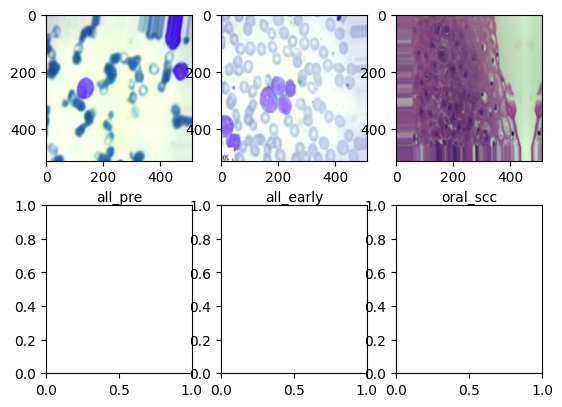

In [7]:

random_num = random.randint(0,len(all_pre_files))
brain_tumor_pic = all_pre_files[random_num]
brain_early_pic = all_early_files[random_num]
oral_scc_pic = oral_scc_files[random_num]
brain_tumor_data = imageio.imread(brain_tumor_pic)
brain_early_data = imageio.imread(brain_early_pic)
oral_scc_data = imageio.imread(oral_scc_pic)
fig,axs = plt.subplots(2,3)
axs[0,0].imshow(brain_tumor_data)
axs[0,1].imshow(brain_early_data)
axs[0,2].imshow(oral_scc_data)
axs[0,0].set_xlabel('all_pre')
axs[0,1].set_xlabel('all_early')
axs[0,2].set_xlabel('oral_scc')
plt.show()

In [11]:

gc.collect()


0

In [12]:

generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)


In [13]:
train_ds = generator.flow_from_directory(
    'mcc2',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
val_ds = generator.flow_from_directory(
    'mcc2',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 12001 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [19]:
train_ds.class_indices

{'all_early': 0, 'all_pre': 1, 'oral_scc': 2}


checkpoint_filepath = 'checkpoint_small'
callback = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)
]


In [20]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_resnet.layers:
    layer.trainable = False
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3   , activation='softmax')(x)
model = Model(inputs=base_model_resnet.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
history = model.fit(train_ds,verbose = 1,epochs = 3,batch_size = 32,validation_data = val_ds,callbacks = callback)

Epoch 1/10
376/376 [==============================] - 827s 2s/step - loss: 0.0442 - accuracy: 0.9838 - val_loss: 0.0312 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 878s 2s/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 0.0027 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 3/10
376/376 [==============================] - 867s 2s/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0021 - val_accuracy: 0.9997 - lr: 0.0010
Epoch 4/10
376/376 [==============================] - 807s 2s/step - loss: 0.0033 - accuracy: 0.9985 - val_loss: 0.0050 - val_accuracy: 0.9977 - lr: 0.0010
Epoch 5/10
376/376 [==============================] - 786s 2s/step - loss: 0.0099 - accuracy: 0.9971 - val_loss: 0.0012 - val_accuracy: 0.9997 - lr: 0.0010
Epoch 6/10
376/376 [==============================] - 733s 2s/step - loss: 5.1539e-04 - accuracy: 0.9999 - val_loss: 0.0027 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 7/10
376/376 [==============================] - 716s 2

In [17]:
model.save('mcc3.h5')